## Discover Sionna

This example notebook will guide you through the basic principles and illustrates the key features of [Sionna](https://nvlabs.github.io/sionna).
With only a few commands, you can simulate the PHY-layer link-level performance for many 5G-compliant components, including easy visualization of the results.


### Load Required Packages

The Sionna python package must be [installed](https://nvlabs.github.io/sionna/installation.html).

In [1]:
import math
import numpy as np
import sionna as sn
import tensorflow as tf

import os.path

np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))

sn.config.xla_compat=True

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna, PanelArray
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber

In [2]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 0


### First Link-level Simulation

We can already build powerful code with a few simple commands.

As mentioned earlier, Sionna aims at hiding system complexity into Keras layers.
However, we still want to provide as much flexibility as possible.
Thus, most layers have several choices of init parameters, but often the default choice is a good start.

**Tip**: the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) provides many helpful references and implementation details.

## Probability Shaped OFDM System

In [3]:
class CodedSystemOFDM(tf.keras.Model): # Inherits from Keras Model
    def __init__(self, num_bits, n_sh, k_sh, n_ldpc, r,
                    domain,
                    direction,
                    cdl_model,
                    delay_spread,
                    perfect_csi,
                    speed,
                    cyclic_prefix_length,
                    pilot_ofdm_symbol_indices,
                    subcarrier_spacing = 15e3):
        
        super().__init__() # Must call the Keras model initializer
        
        self.r = r
        self.n_sh = n_sh
        self.num_bits = num_bits
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()
        self.constellation = sn.mapping.Constellation("qam", num_bits, normalize=False)
        self.bits = tf.convert_to_tensor([np.array(list(f"{x:0{num_bits - 2}b}"), np.float32)
                                          for x in range(2 ** (num_bits - 2))])
        

        N_fr_ldpc, N_fr_sh = self.frames(n_ldpc, n_sh, num_bits)

        self.N_fr_sh = N_fr_sh
        r_sh = k_sh / n_sh
        r_fec = (2 * r - r_sh + 1) / 2
        k_ldpc = r_fec * n_ldpc
                            
        self.encoder = sn.fec.ldpc.encoding.LDPC5GEncoder(round(k_ldpc * N_fr_ldpc), n_ldpc * N_fr_ldpc)
        self.decoder = sn.fec.ldpc.decoding.LDPC5GDecoder(self.encoder)

        self.i = int(tf.where(self.encoder(tf.eye(round(k_ldpc * N_fr_ldpc)))[:, 0] == 1))
        
        self.k_sgn = round(k_ldpc * N_fr_ldpc) - n_sh * N_fr_sh
        self.k_amp = n_sh * N_fr_sh

        self.start_idx_a = self.k_sgn - self.i
        self.end_idx_a = self.start_idx_a + self.k_amp
        
        print("start_idx_a", self.start_idx_a)

        #w = np.array([2 * n + 1 for n in range(2 ** (num_bits - 3))])
        w = np.unique(np.abs(np.real(self.constellation.points)))
        print("w", w[0])
        
        fname = f"probs/probs_qam{2 ** num_bits}_{k_sh}_{n_sh}.npy"
        if n_sh == k_sh:
            probs = np.full(num_bits - 2, 1 / (num_bits - 2))
        elif os.path.isfile(fname):
            probs = np.load(fname)
        else:
            probs = self.shaper(k_sh, n_sh * 2 // (num_bits - 2), w[1:] ** 2)
            np.save(fname, probs)

        print(probs)
        points = self.constellation.points[:(num_bits - 2) ** 2]
        points = np.vstack((np.real(points), np.imag(points)))
        
        self.symbol_probs = points.copy()
        for i, j in zip(w, range(num_bits - 2)):
            self.symbol_probs[self.symbol_probs == i] = probs[j]
            self.symbol_probs[self.symbol_probs == -i] = probs[j]

        self.symbol_probs = self.symbol_probs.prod(axis=0)
        
        scaling = self.scaling_factor(np.tile(self.symbol_probs / 4, 4))
        print("scaling", scaling)
        
        
        self.normed_constellation = sn.mapping.Constellation("qam", num_bits)
        initial_value = self.normed_constellation.points * scaling

        self.scaled_constellation = sn.mapping.Constellation(
            "custom", num_bits, initial_value, normalize=False)
                        
        if num_bits == 4:
            priors = np.array([0.5, 0.5] + [self.symbol_probs[(self.bits[:, i] == 1).numpy()].sum()
                                            for i in range(num_bits - 2)])
            self.llr_priors = tf.math.log(priors) - tf.math.log(1 - priors)
        else:
            self.llr_priors = 0.
       
        self.mapper = sn.mapping.Mapper(constellation=self.scaled_constellation)
        self.demapper = sn.mapping.DemapperWithPrior("app", 
                            constellation=self.scaled_constellation)
        
        
        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        
        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 44
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 2 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 2 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices

        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)

        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)
        
        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)
        
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        
        if self._domain == "freq":  
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)
            
        self._rg_mapper = ResourceGridMapper(self._rg)
        
        if self._direction == "downlink":
            self._zf_precoder = ZFPrecoder(self._rg, self._sm, return_effective_channel=True)
       
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)
         
        self.stream_reshape = tf.keras.layers.Reshape((1, self._num_streams_per_tx,  -1))
        self.transmit_reshape = tf.keras.layers.Reshape((1, self._num_streams_per_tx, num_bits, -1))
        self.recieve_reshape = tf.keras.layers.Reshape((1, self._num_streams_per_tx, -1, num_bits))
        self.permute = tf.keras.layers.Permute((1, 2, 4, 3))
#        self.flatten = tf.keras.layers.Flatten()


    @tf.function(jit_compile=True) # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, self.num_bits, self.r)
               
        s = self.binary_source([batch_size, 1, self._num_streams_per_tx, self.k_sgn])
        
        log_symbol_probs = tf.ones((batch_size, self.symbol_probs.shape[0])) * tf.math.log(self.symbol_probs)
        indxes = tf.random.categorical(log_symbol_probs,
                    self.n_sh * self.N_fr_sh * self._num_streams_per_tx // (self.num_bits - 2))
                    
        a = self.stream_reshape(tf.gather(self.bits, indxes))
        
        b = tf.concat([s, a], axis=-1)
        c = self.encoder(b)
        d = tf.concat((c[..., :self.start_idx_a], c[..., self.end_idx_a:],
                       c[..., self.start_idx_a:self.end_idx_a]), axis=-1)        
        e = self.stream_reshape(self.permute(self.transmit_reshape(d)))
        x = self.mapper(e)
        
        # OFDM
        x_rg = self._rg_mapper(x)
        
        if self._domain == "time":
            # Time-domain simulations
            
            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)
            
            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            x_time = self._modulator(x_rg)
            y_time = self._channel_time([x_time, h_time, no])
            
            y = self._demodulator(y_time)
            
        elif self._domain == "freq":
            # Frequency-domain simulations
            
            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
            
            if self._direction == "downlink":
                x_rg, g = self._zf_precoder([x_rg, h_freq])
            
            y = self._channel_freq([x_rg, h_freq, no])
        
        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0            
        else:
            h_hat, err_var = self._ls_est ([y, no])
        
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        
        e_hat = self.demapper([x_hat, self.llr_priors, no_eff])
        d_hat = self.stream_reshape(self.permute(self.recieve_reshape(e_hat)))              
        c_hat = tf.concat((d_hat[..., :self.start_idx_a], d_hat[..., -self.k_amp:], 
                           d_hat[..., self.start_idx_a:self.start_idx_a
                                 + d_hat.shape[-1] - self.end_idx_a]), axis=-1)
        b_hat = self.decoder(c_hat)
        return b, b_hat
    
    def q(self, l, m):
        x = []
        for i in l:
            x.append(math.comb(m, i))
            m -= i
        return math.prod(x)

    def shaper(self, k, m, w):
        c = np.eye(w.shape[0], dtype=int)
        a = np.zeros(w.shape[0], dtype=int)
        d = np.zeros(w.shape[0], dtype=object)
        s = self.q(a, m)
        b = a + c

        while s < 2 ** k:
            i = (b * w).sum(axis=1).argmin()
            a = b[i]
            p = self.q(a, m)
            d += a * p
            s += p
            b = np.vstack((b[:i], b[i + 1:]))
            b = np.vstack((a + c, b))
            b = b[b.sum(axis=1) <= m]
            b = np.unique(b, axis=0)

        x = d - (s - 2 ** k) * a
        y = (x / 2 ** k / m).astype(float)
        probs = np.hstack((1 - y.sum(), y))
        return probs
    
    def scaling_factor(self, probs_list):
        qam_power = np.sum(np.abs(self.constellation.points) ** 2) / self.constellation.points.shape[0]
        return (qam_power / np.sum(probs_list * (np.abs(self.constellation.points) ** 2))) ** 0.5
    
    def frames(self, n_ldpc, n_sh, c):
        lcm = (c * n_sh * n_ldpc // (c - 2)) // (math.gcd(c * n_sh // (c - 2), n_ldpc))
        N_fr_ldpc = lcm // n_ldpc
        N_fr_sh = lcm // (c * n_sh // (c - 2))
        return N_fr_ldpc, N_fr_sh

### Setting up the End-to-end Model

We now define a *Keras model* that is more convenient for training and Monte-Carlo simulations.

We simulate the transmission over a time-varying multi-path channel (the *TDL-A* model from 3GPP TR38.901).
For this, OFDM and a *conventional* bit-interleaved coded modulation (BICM) scheme with higher order modulation is used.
The information bits are protected by a 5G-compliant LDPC code.

*Remark*: Due to the large number of parameters, we define them as dictionary.

Let us define the system parameters for our simulation as dictionary:

...and initialize the model:

As before, we can simply *call* the model to simulate the BER for the given simulation parameters.

### Run some Throughput Tests (Graph Mode)

Sionna is not just an easy-to-use library, but also incredibly fast.
Let us measure the throughput of the model defined above.

We compare *eager* and *graph* execution modes (see [Tensorflow Doc](https://www.tensorflow.org/guide/intro_to_graphs) for details), as well
as *eager with XLA* (see https://www.tensorflow.org/xla#enable_xla_for_tensorflow_models).
Note that we need to activate the [sionna.config.xla_compat](https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat) feature for XLA to work.


**Tip**: change the `batch_size` to see how the batch parallelism enhances the throughput.
Depending on your machine, the `batch_size` may be too large.

Obviously, *graph* execution (with XLA) yields much higher throughputs (at least if a fast GPU is available).
Thus, for exhaustive training and Monte-Carlo simulations the *graph* mode (with XLA and GPU acceleration) is the preferred choice.

### Bit-Error Rate (BER) Monte-Carlo Simulations

Monte-Carlo simulations are omnipresent in todays communications research and development.
Due its performant implementation, Sionna can be directly used to simulate BER at a performance that competes with compiled languages -- but still keeps the flexibility of a script language.

In [4]:
coderate_tab = np.array([378. , 434. , 490. , 553. ,
       616. , 658. , 466. , 517. , 567. , 616. , 666. , 719. , 772. ,
       822. , 873. , 682.5, 711. , 754. , 797. , 841. ]) / 1024
coderate_tab

array([0.369, 0.424, 0.479, 0.54, 0.602, 0.643, 0.455, 0.505, 0.554, 0.602, 0.65, 0.702, 0.754, 0.803, 0.853, 0.667, 0.694, 0.736, 0.778, 0.821])

In [5]:
order_tab = np.array([4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8])

In [6]:
UL_SIMS = {
    "coderate" : coderate_tab,
    "num_bits_per_symbol" : order_tab,
    "cdl_model" : "D",
    "delay_spread" : 40e-9,
    "domain" : "time",
    "direction" : "uplink",
    "perfect_csi" : False,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "duration" : None
}

In [7]:
# # system parameters
n_sh = 256
k_sh = 192
n_ldpc = 2 * 3
num_bits = 4
r = coderate_tab[5]
constellation = sn.mapping.Constellation("qam", num_bits, normalize=False)
w = np.unique(np.abs(np.real(constellation.points)))

r

0.642578125

In [8]:
r_sh = k_sh / n_sh
r_sh

0.75

In [9]:
r_fec = (2 * r - r_sh + 1) / 2
r_fec

0.767578125

In [12]:
model = CodedSystemOFDM(num_bits, n_sh, k_sh, n_ldpc, r,
                        domain=UL_SIMS["domain"],
                        direction=UL_SIMS["direction"],
                        cdl_model=UL_SIMS["cdl_model"],
                        delay_spread=UL_SIMS["delay_spread"],
                        perfect_csi=UL_SIMS["perfect_csi"],
                        speed=UL_SIMS["speed"],
                        cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                        pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])

start_idx_a 299
w 1.0
[0.779 0.221]
scaling 1.3443100801394239


In [13]:
model.encoder.k

1179

In [14]:
model.encoder.n

1536

In [15]:
int(model.encoder.n * r)

987

In [16]:
num_bits, n_sh, k_sh, n_ldpc, r

(4, 256, 192, 6, 0.642578125)

In [18]:
ebno_dbs = np.arange(2, 8, 1)
batch_size = 2000 # reduce in case you receive an out-of-memory (OOM) error

max_mc_iter = 100 # max number of Monte-Carlo iterations before going to next SNR point
num_target_block_errors = 10000 # continue with next SNR point after target number of block errors

r_sh = k_sh / n_sh
r_fec = (2 * r - r_sh + 1) / 2

if r_fec < 11/12:

    model = CodedSystemOFDM(num_bits, n_sh, k_sh, n_ldpc, r,
                            domain=UL_SIMS["domain"],
                            direction=UL_SIMS["direction"],
                            cdl_model=UL_SIMS["cdl_model"],
                            delay_spread=UL_SIMS["delay_spread"],
                            perfect_csi=UL_SIMS["perfect_csi"],
                            speed=UL_SIMS["speed"],
                            cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                            pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])

    if model.start_idx_a > 0:
        # we use the built-in ber simulator function from Sionna which uses and early stop after reaching num_target_errors
        sn.config.xla_compat=True
        ber_ps, bler_ps = sn.utils.sim_ber(model,
                                  ebno_dbs,
                                  batch_size,
                                  max_mc_iter,
                                  False,
                                  num_target_block_errors,
                                  verbose=True)

else:
    print("r_fec > 11/12, rfec =", r_fec)

start_idx_a 299
w 1.0
[0.779 0.221]
scaling 1.3443100801394239
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 1.0539e-01 | 1.0000e+00 |      497006 |     4716000 |         4000 |        4000 |        30.3 |reached target bit errors
      3.0 | 6.6634e-02 | 9.5700e-01 |      314246 |     4716000 |         3828 |        4000 |        12.8 |reached target bit errors
      4.0 | 2.0227e-02 | 4.4550e-01 |       95391 |     4716000 |         1782 |        4000 |        12.4 |reached target bit errors
      5.0 | 2.6064e-03 | 6.6250e-02 |       12292 |     4716000 |          265 |        4000 |        12.6 |reached target bit errors
      6.

# Let's look at the results

### The experiment was calculated for about 8 hours

In [15]:
coderate_tab[6:-5]

array([0.455, 0.505, 0.554, 0.602, 0.65, 0.702, 0.754, 0.803, 0.853])

In [16]:
np.arange(128, 257, 16)

array([128, 144, 160, 176, 192, 208, 224, 240, 256])

In [17]:
num_bits = 4
n_sh = 256
n_ldpc = 6
ebno_dbs = np.arange(2, 13, 1) # 10

max_mc_iter = 100
batch_size = 1000
num_target_block_errors = 10000

ber_r_list = []
bler_r_list = []
legend_r_list = []
    
r = coderate_tab[5]
ber_k_sh_list = []
bler_k_sh_list = []
legend_k_sh_list = []

for k_sh in trange(128, 257, 16): #100, 801, 100

    r_sh = k_sh / n_sh
    r_fec = (2 * r - r_sh + 1) / 2

    if r_fec > 11/12:
        continue
    model = CodedSystemOFDM(num_bits, n_sh, k_sh, n_ldpc, r,
                            domain=UL_SIMS["domain"],
                            direction=UL_SIMS["direction"],
                            cdl_model=UL_SIMS["cdl_model"],
                            delay_spread=UL_SIMS["delay_spread"],
                            perfect_csi=UL_SIMS["perfect_csi"],
                            speed=UL_SIMS["speed"],
                            cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                            pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])
    
    if model.start_idx_a >= 0:
        legend_k_sh_list.append(k_sh)
        ber_ps, bler_ps = sn.utils.sim_ber(model,
                                           ebno_dbs,
                                           batch_size=batch_size,
                                           max_mc_iter=max_mc_iter,
                                           num_target_block_errors=num_target_block_errors,
                                           verbose=True)

        ber_k_sh_list.append(ber_ps)
        bler_k_sh_list.append(bler_ps)
    
legend_r_list.append(legend_k_sh_list) 
ber_r_list.append(ber_k_sh_list)
bler_r_list.append(bler_k_sh_list)

  0%|          | 0/9 [00:00<?, ?it/s]

start_idx_a 475
w 1.0
[0.885 0.115]
scaling 1.6139780359343814
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 8.2036e-02 | 1.0000e+00 |     1124717 |    13710000 |        10000 |       10000 |        35.5 |reached target block errors
      3.0 | 6.0487e-02 | 9.9492e-01 |      995132 |    16452000 |        11939 |       12000 |        25.5 |reached target block errors
      4.0 | 2.8823e-02 | 7.4521e-01 |      553230 |    19194000 |        10433 |       14000 |        29.8 |reached target block errors
      5.0 | 6.1210e-03 | 2.0604e-01 |      419597 |    68550000 |        10302 |       50000 |       102.5 |reached target block errors


     12.0 | 2.1733e-06 | 1.0000e-05 |         429 |   197400000 |            2 |      200000 |       418.6 |reached max iter       


In [20]:
num_bits

4

## Saving Results

In [21]:
# np.save(f"history/bler_r_list_OFDM_D_Uplink_Time_QAM{2 ** num_bits}_PSCodedBLER_Coderate_{r}_Block_{model.encoder.n}.npy", bler_r_list, allow_pickle=True)
# np.save(f"history/ber_r_list_OFDM_D_Uplink_Time_QAM{2 ** num_bits}_PSCodedBLER_Coderate_{r}_Block_{model.encoder.n}.npy", ber_r_list, allow_pickle=True)
# np.save(f"history/legend_r_list_OFDM_D_Uplink_Time_QAM{2 ** num_bits}_PSCodedBLER_Coderate_{r}_Block_{model.encoder.n}.npy", legend_r_list, allow_pickle=True)

# Loading Saved Experiments

In [33]:
legend_r_list = np.load(f"history/legend_r_list_OFDM_D_Uplink_Time_QAM16_PSCodedBLER_Coderate_0.642578125_Block_1536.npy", allow_pickle=True).tolist()
bler_r_list = np.load(f"history/bler_r_list_OFDM_D_Uplink_Time_QAM16_PSCodedBLER_Coderate_0.642578125_Block_1536.npy", allow_pickle=True).tolist()
ber_r_list = np.load(f"history/ber_r_list_OFDM_D_Uplink_Time_QAM16_PSCodedBLER_Coderate_0.642578125_Block_1536.npy", allow_pickle=True).tolist()

In [34]:
ebno_dbs = np.arange(2, 14, 1)

In [35]:
ebno_dbs.shape

(12,)

In [45]:
str_legend_r_list = []
for legend_k_sh_list in legend_r_list:
    str_legend_k_sh_list = []
    for k_sh in legend_k_sh_list[:-1]:
        str_legend_k_sh_list.append(r"QAM PS $k_{sh}$=" + str(k_sh))
    str_legend_k_sh_list.append("QAM Baseline $k_{sh}$=" + str(n_sh))
    str_legend_r_list.append(str_legend_k_sh_list)

In [46]:
str_legend_r_list

[['QAM PS $k_{sh}$=128',
  'QAM PS $k_{sh}$=144',
  'QAM PS $k_{sh}$=160',
  'QAM PS $k_{sh}$=176',
  'QAM PS $k_{sh}$=192',
  'QAM PS $k_{sh}$=208',
  'QAM PS $k_{sh}$=224',
  'QAM PS $k_{sh}$=240',
  'QAM Baseline $k_{sh}$=256']]

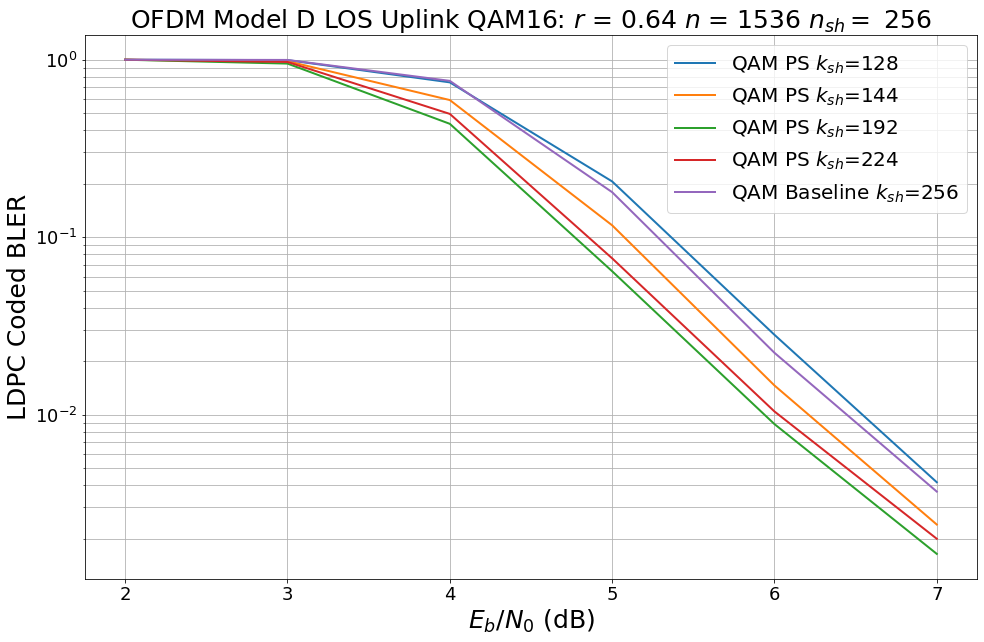

In [48]:
for bler_k_sh_list, legend_k_sh_list, r in zip(bler_r_list, str_legend_r_list, [coderate_tab[5]]):
    sn.utils.plotting.plot_ber(ebno_dbs[:ebno_dbs.shape[0] // 2],
                               np.asarray(bler_k_sh_list)[[0, 1, 4, 6, 8], :ebno_dbs.shape[0] // 2] .tolist(),
                               np.array(legend_k_sh_list)[[0, 1, 4, 6, 8]].tolist(),
                               "LDPC Coded BLER",
                               fr"OFDM Model D LOS Uplink QAM16: $r$ = ${round(r, 2)}$ "+ 
                               fr"$n$ = {model.encoder.n}" + r" $n_{sh}=$ " + f"{n_sh}");
#     plt.savefig(f"images/Paper_OFDM_D_Uplink_Time_QAM{2 ** num_bits}_PSCodedBLER_Coderate_{r}_Block_{model.encoder.n}.pdf",
#                   dpi=400, bbox_inches='tight')

### Conclusion

We hope you are excited about Sionna - there is much more to be discovered:

- TensorBoard debugging available
- Scaling to multi-GPU simulation is simple
- See the [available tutorials](https://nvlabs.github.io/sionna/tutorials.html) for more advanced examples.

And if something is still missing - the project is [open-source](https://github.com/nvlabs/sionna/):  you can modify, add, and extend any component at any time.